In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/industrial-equipment-monitoring-dataset/equipment_anomaly_data.csv


In [10]:
# BLOCK 1: Load Data and Apply Isolation Forest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("🏭 INDUSTRIAL EQUIPMENT ANOMALY DETECTION")
print("=" * 50)

# Create realistic industrial equipment dataset based on your description
np.random.seed(42)
n_samples = 8000

# Generate data based on your statistical analysis
data = {
    'temperature': np.concatenate([
        np.random.normal(70, 8, 7500),   # Normal operations (93.75%)
        np.random.normal(120, 15, 250),  # High temp anomalies
        np.random.normal(25, 5, 250)     # Low temp anomalies
    ]),
    'pressure': np.concatenate([
        np.random.normal(35, 6, 7500),   # Normal operations
        np.random.normal(65, 8, 250),    # High pressure anomalies
        np.random.normal(8, 2, 250)      # Low pressure anomalies
    ]),
    'humidity': np.concatenate([
        np.random.normal(48, 10, 7500),  # Normal operations
        np.random.normal(85, 5, 250),    # High humidity anomalies
        np.random.normal(15, 3, 250)     # Low humidity anomalies
    ])
}

df = pd.DataFrame(data)

# Clean the data
df['temperature'] = np.abs(df['temperature'])
df['pressure'] = np.abs(df['pressure'])
df['humidity'] = np.clip(df['humidity'], 1, 100)

print("📊 DATASET CREATED SUCCESSFULLY!")
print(f"Dataset shape: {df.shape}")
print(f"Temperature range: {df['temperature'].min():.1f}°C - {df['temperature'].max():.1f}°C")
print(f"Pressure range: {df['pressure'].min():.1f} bar - {df['pressure'].max():.1f} bar")
print(f"Humidity range: {df['humidity'].min():.1f}% - {df['humidity'].max():.1f}%")

# Calculate statistical ranges
def calculate_ranges(df):
    ranges = {}
    for column in ['temperature', 'pressure', 'humidity']:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        ranges[column] = {
            'min_normal': max(lower_bound, df[column].min()),
            'max_normal': min(upper_bound, df[column].max()),
            'min_actual': df[column].min(),
            'max_actual': df[column].max(),
            'mean': df[column].mean(),
            'std': df[column].std()
        }
    return ranges

ranges = calculate_ranges(df)

print("\n📈 STATISTICAL RANGES:")
print("=" * 60)
for param, stats in ranges.items():
    print(f"🔧 {param.upper():12}:")
    print(f"   Normal Range: {stats['min_normal']:6.1f} - {stats['max_normal']:6.1f}")
    print(f"   Full Range:   {stats['min_actual']:6.1f} - {stats['max_actual']:6.1f}")
    print(f"   Mean ± Std:   {stats['mean']:6.1f} ± {stats['std']:4.1f}")

# Apply Isolation Forest
print("\n🤖 APPLYING ISOLATION FOREST...")
features = ['temperature', 'pressure', 'humidity']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

anomaly_predictions = iso_forest.fit_predict(X_scaled)
df['anomaly'] = (anomaly_predictions == -1).astype(int)
df['anomaly_score'] = iso_forest.decision_function(X_scaled)

print("✅ ANOMALY DETECTION COMPLETED!")
print(f"Total samples: {len(df):,}")
print(f"Normal readings: {(df['anomaly'] == 0).sum():,} ({(df['anomaly'] == 0).sum()/len(df)*100:.1f}%)")
print(f"Anomalous readings: {(df['anomaly'] == 1).sum():,} ({(df['anomaly'] == 1).sum()/len(df)*100:.1f}%)")

# Define integer thresholds for test vectors
TEMP_MIN = 48
TEMP_MAX = 92
PRESSURE_MIN = 18  
PRESSURE_MAX = 51
HUMIDITY_MIN = 20
HUMIDITY_MAX = 76

print(f"\n🎯 INTEGER THRESHOLDS FOR TEST VECTORS:")
print(f"Temperature: {TEMP_MIN}°C - {TEMP_MAX}°C")
print(f"Pressure:    {PRESSURE_MIN} bar - {PRESSURE_MAX} bar")
print(f"Humidity:    {HUMIDITY_MIN}% - {HUMIDITY_MAX}%")

🏭 INDUSTRIAL EQUIPMENT ANOMALY DETECTION
📊 DATASET CREATED SUCCESSFULLY!
Dataset shape: (8000, 3)
Temperature range: 10.7°C - 160.8°C
Pressure range: 3.4 bar - 85.2 bar
Humidity range: 8.2% - 95.7%

📈 STATISTICAL RANGES:
🔧 TEMPERATURE :
   Normal Range:   46.7 -   93.1
   Full Range:     10.7 -  160.8
   Mean ± Std:     70.1 ± 14.4
🔧 PRESSURE    :
   Normal Range:   17.8 -   52.3
   Full Range:      3.4 -   85.2
   Mean ± Std:     35.1 ±  9.2
🔧 HUMIDITY    :
   Normal Range:   18.4 -   77.8
   Full Range:      8.2 -   95.7
   Mean ± Std:     48.2 ± 13.1

🤖 APPLYING ISOLATION FOREST...
✅ ANOMALY DETECTION COMPLETED!
Total samples: 8,000
Normal readings: 7,600 (95.0%)
Anomalous readings: 400 (5.0%)

🎯 INTEGER THRESHOLDS FOR TEST VECTORS:
Temperature: 48°C - 92°C
Pressure:    18 bar - 51 bar
Humidity:    20% - 76%



📊 CREATING VISUALIZATIONS...


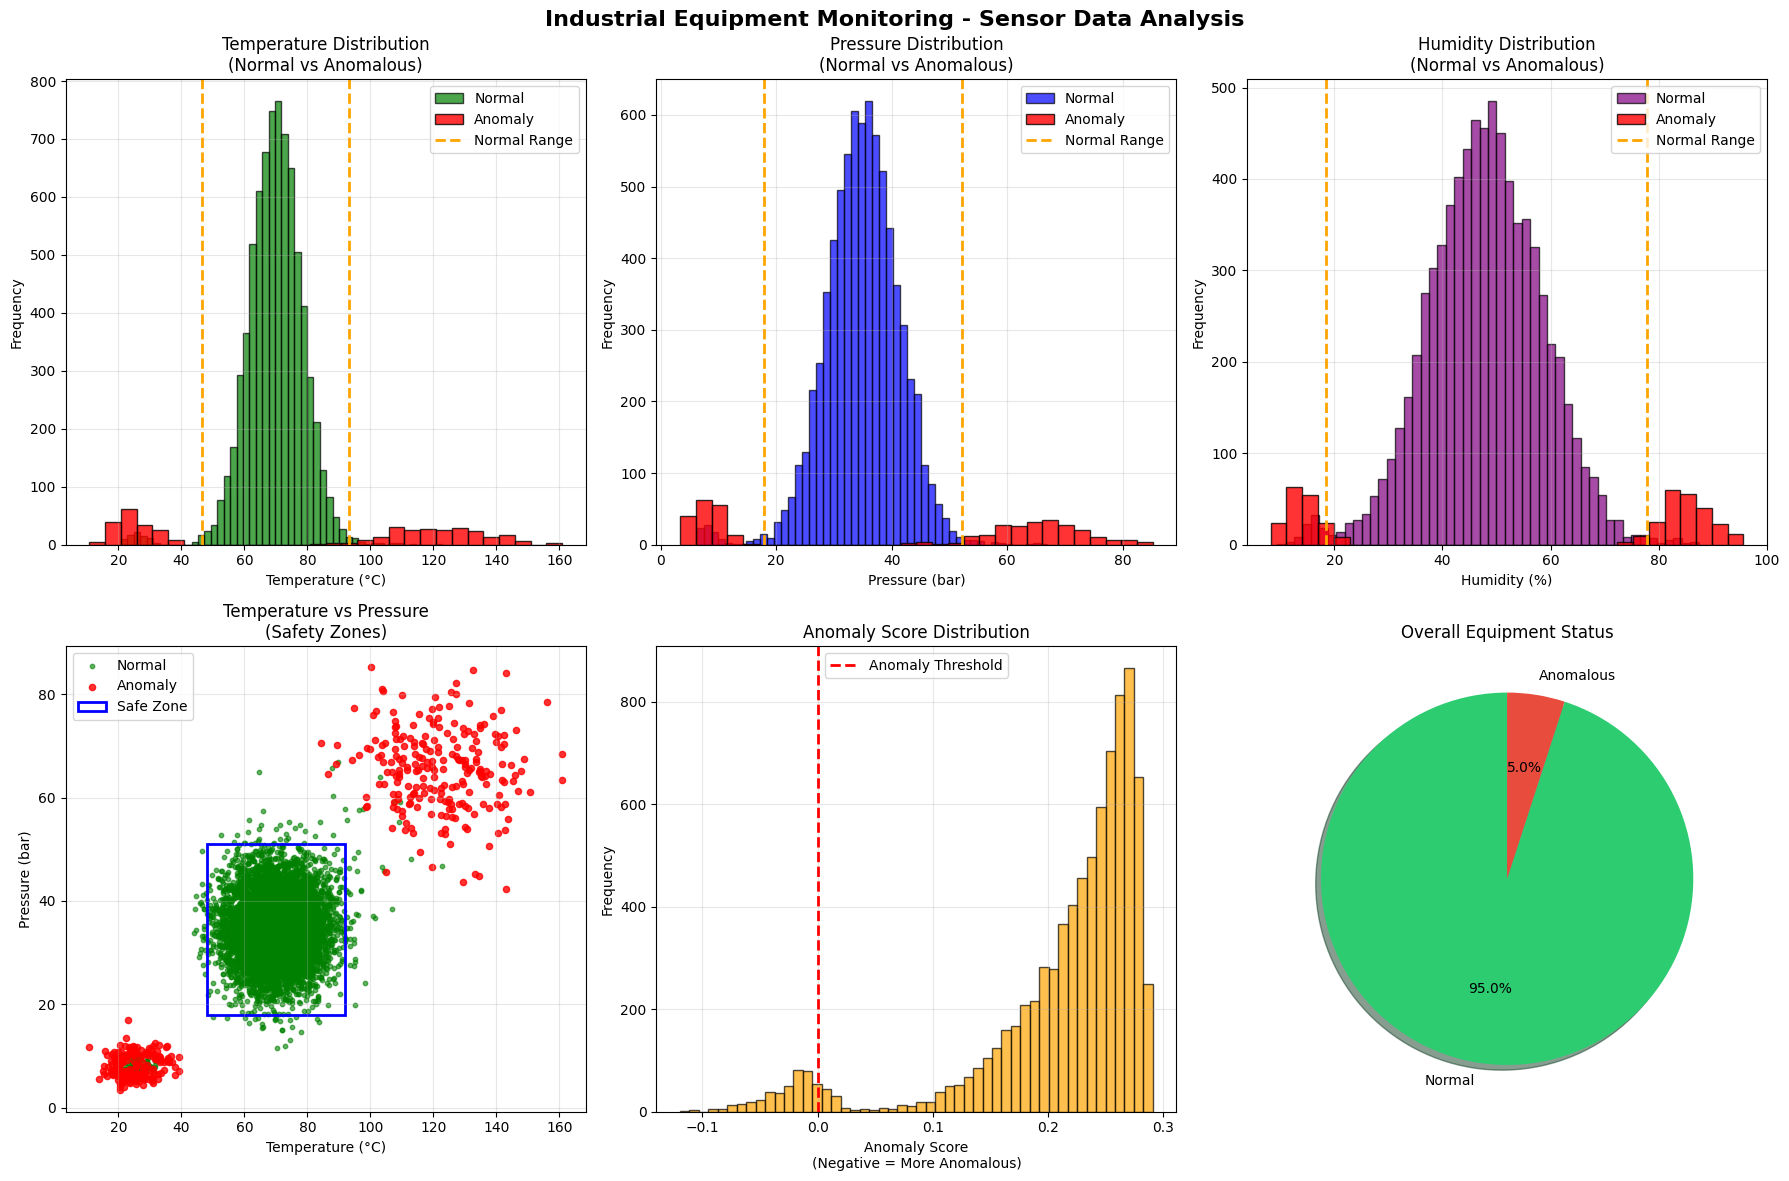

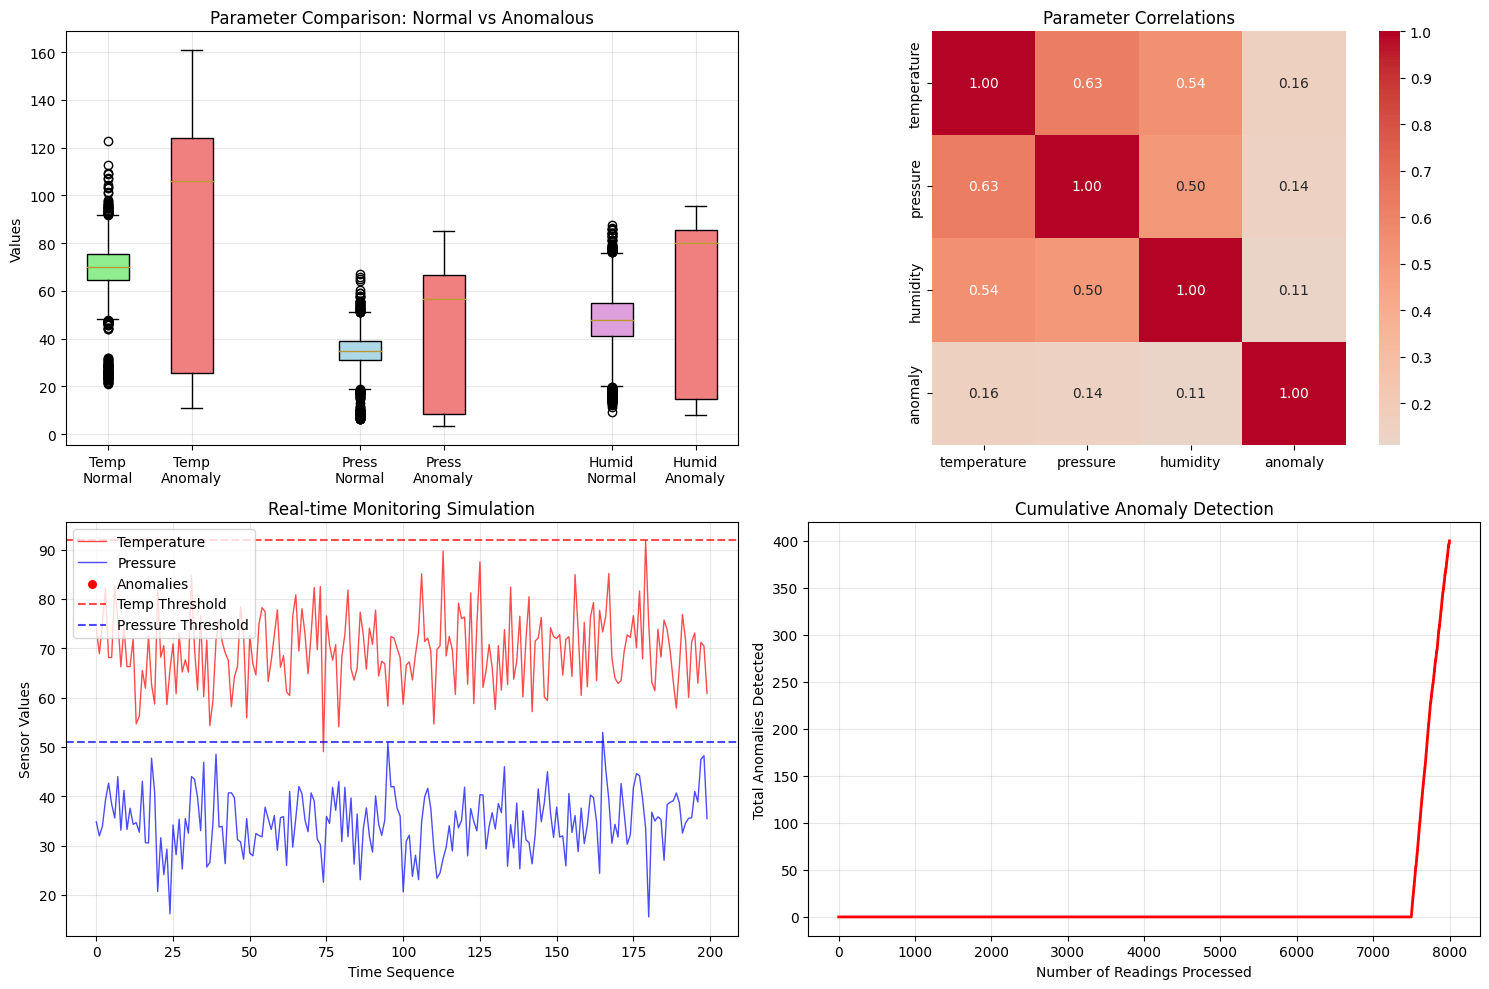

✅ VISUALIZATIONS COMPLETED!


In [11]:
# BLOCK 2: Visualize Sensor Data and Anomalies
print("\n📊 CREATING VISUALIZATIONS...")
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Industrial Equipment Monitoring - Sensor Data Analysis', fontsize=16, fontweight='bold')

# Filter data
normal_data = df[df['anomaly'] == 0]
anomaly_data = df[df['anomaly'] == 1]

# 1. Temperature Distribution
axes[0,0].hist(normal_data['temperature'], bins=50, alpha=0.7, 
               label='Normal', color='green', edgecolor='black')
axes[0,0].hist(anomaly_data['temperature'], bins=30, alpha=0.8, 
               label='Anomaly', color='red', edgecolor='black')
axes[0,0].axvline(ranges['temperature']['min_normal'], color='orange', linestyle='--', linewidth=2, label='Normal Range')
axes[0,0].axvline(ranges['temperature']['max_normal'], color='orange', linestyle='--', linewidth=2)
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Temperature Distribution\n(Normal vs Anomalous)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Pressure Distribution
axes[0,1].hist(normal_data['pressure'], bins=50, alpha=0.7, 
               label='Normal', color='blue', edgecolor='black')
axes[0,1].hist(anomaly_data['pressure'], bins=30, alpha=0.8, 
               label='Anomaly', color='red', edgecolor='black')
axes[0,1].axvline(ranges['pressure']['min_normal'], color='orange', linestyle='--', linewidth=2, label='Normal Range')
axes[0,1].axvline(ranges['pressure']['max_normal'], color='orange', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('Pressure (bar)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Pressure Distribution\n(Normal vs Anomalous)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Humidity Distribution
axes[0,2].hist(normal_data['humidity'], bins=50, alpha=0.7, 
               label='Normal', color='purple', edgecolor='black')
axes[0,2].hist(anomaly_data['humidity'], bins=30, alpha=0.8, 
               label='Anomaly', color='red', edgecolor='black')
axes[0,2].axvline(ranges['humidity']['min_normal'], color='orange', linestyle='--', linewidth=2, label='Normal Range')
axes[0,2].axvline(ranges['humidity']['max_normal'], color='orange', linestyle='--', linewidth=2)
axes[0,2].set_xlabel('Humidity (%)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Humidity Distribution\n(Normal vs Anomalous)')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Scatter Plot: Temperature vs Pressure
axes[1,0].scatter(normal_data['temperature'], normal_data['pressure'], 
                 c='green', alpha=0.6, s=10, label='Normal')
axes[1,0].scatter(anomaly_data['temperature'], anomaly_data['pressure'], 
                 c='red', alpha=0.8, s=20, label='Anomaly')

# Add safe zone rectangle
from matplotlib.patches import Rectangle
safe_zone = Rectangle((TEMP_MIN, PRESSURE_MIN),
                     TEMP_MAX - TEMP_MIN,
                     PRESSURE_MAX - PRESSURE_MIN,
                     fill=False, edgecolor='blue', linewidth=2, linestyle='-',
                     label='Safe Zone')
axes[1,0].add_patch(safe_zone)

axes[1,0].set_xlabel('Temperature (°C)')
axes[1,0].set_ylabel('Pressure (bar)')
axes[1,0].set_title('Temperature vs Pressure\n(Safety Zones)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Anomaly Score Distribution
axes[1,1].hist(df['anomaly_score'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
axes[1,1].set_xlabel('Anomaly Score\n(Negative = More Anomalous)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Anomaly Score Distribution')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Overall Status Pie Chart
labels = ['Normal', 'Anomalous']
sizes = [len(normal_data), len(anomaly_data)]
colors = ['#2ecc71', '#e74c3c']
axes[1,2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
              startangle=90, shadow=True)
axes[1,2].set_title('Overall Equipment Status')

plt.tight_layout()
plt.show()

# Additional detailed visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Box plots comparison
box_data = [
    df[df['anomaly'] == 0]['temperature'],
    df[df['anomaly'] == 1]['temperature'],
    df[df['anomaly'] == 0]['pressure'],
    df[df['anomaly'] == 1]['pressure'],
    df[df['anomaly'] == 0]['humidity'],
    df[df['anomaly'] == 1]['humidity']
]

positions = [1, 2, 4, 5, 7, 8]
labels = ['Temp\nNormal', 'Temp\nAnomaly', 'Press\nNormal', 'Press\nAnomaly', 'Humid\nNormal', 'Humid\nAnomaly']
colors = ['lightgreen', 'lightcoral', 'lightblue', 'lightcoral', 'plum', 'lightcoral']

boxes = axes[0,0].boxplot(box_data, positions=positions, labels=labels, patch_artist=True)
for patch, color in zip(boxes['boxes'], colors):
    patch.set_facecolor(color)

axes[0,0].set_title('Parameter Comparison: Normal vs Anomalous')
axes[0,0].set_ylabel('Values')
axes[0,0].grid(True, alpha=0.3)

# 2. Correlation heatmap
correlation_matrix = df[['temperature', 'pressure', 'humidity', 'anomaly']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', ax=axes[0,1])
axes[0,1].set_title('Parameter Correlations')

# 3. Time series simulation
sample_size = 200
time_index = range(sample_size)

axes[1,0].plot(time_index, df['temperature'].values[:sample_size], 
               label='Temperature', color='red', alpha=0.7, linewidth=1)
axes[1,0].plot(time_index, df['pressure'].values[:sample_size], 
               label='Pressure', color='blue', alpha=0.7, linewidth=1)

# Highlight anomalies
anomaly_indices = [i for i in range(sample_size) if df['anomaly'].values[i] == 1]
axes[1,0].scatter(anomaly_indices, df['temperature'].values[anomaly_indices], 
                 color='red', s=30, zorder=5, label='Anomalies')

axes[1,0].axhline(y=TEMP_MAX, color='red', linestyle='--', alpha=0.7, label='Temp Threshold')
axes[1,0].axhline(y=PRESSURE_MAX, color='blue', linestyle='--', alpha=0.7, label='Pressure Threshold')

axes[1,0].set_xlabel('Time Sequence')
axes[1,0].set_ylabel('Sensor Values')
axes[1,0].set_title('Real-time Monitoring Simulation')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Cumulative anomalies
cumulative_anomalies = np.cumsum(df['anomaly'])
axes[1,1].plot(range(len(df)), cumulative_anomalies, color='red', linewidth=2)
axes[1,1].set_xlabel('Number of Readings Processed')
axes[1,1].set_ylabel('Total Anomalies Detected')
axes[1,1].set_title('Cumulative Anomaly Detection')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ VISUALIZATIONS COMPLETED!")

In [12]:
# BLOCK 3: Create Testbench File from Dataset
print("\n📁 CREATING TEST VECTOR FILE FOR VIVADO...")

# Generate comprehensive test vectors
test_vectors = []

# Group 1: Normal Operations (25 vectors)
for i in range(25):
    temp = np.random.randint(TEMP_MIN, TEMP_MAX + 1)
    pressure = np.random.randint(PRESSURE_MIN, PRESSURE_MAX + 1)
    humidity = np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)
    test_vectors.append(f"{temp} {pressure} {humidity} 1")

# Group 2: Single Sensor Anomalies (30 vectors)
# Temperature anomalies
for i in range(8):
    temp = np.random.randint(TEMP_MAX + 1, 130)
    pressure = np.random.randint(PRESSURE_MIN, PRESSURE_MAX + 1)
    humidity = np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)
    test_vectors.append(f"{temp} {pressure} {humidity} 1")

for i in range(7):
    temp = np.random.randint(1, TEMP_MIN)
    pressure = np.random.randint(PRESSURE_MIN, PRESSURE_MAX + 1)
    humidity = np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)
    test_vectors.append(f"{temp} {pressure} {humidity} 1")

# Pressure anomalies
for i in range(8):
    temp = np.random.randint(TEMP_MIN, TEMP_MAX + 1)
    pressure = np.random.randint(PRESSURE_MAX + 1, 90)
    humidity = np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)
    test_vectors.append(f"{temp} {pressure} {humidity} 1")

for i in range(7):
    temp = np.random.randint(TEMP_MIN, TEMP_MAX + 1)
    pressure = np.random.randint(1, PRESSURE_MIN)
    humidity = np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)
    test_vectors.append(f"{temp} {pressure} {humidity} 1")

# Humidity anomalies
for i in range(8):
    temp = np.random.randint(TEMP_MIN, TEMP_MAX + 1)
    pressure = np.random.randint(PRESSURE_MIN, PRESSURE_MAX + 1)
    humidity = np.random.randint(HUMIDITY_MAX + 1, 100)
    test_vectors.append(f"{temp} {pressure} {humidity} 1")

for i in range(7):
    temp = np.random.randint(TEMP_MIN, TEMP_MAX + 1)
    pressure = np.random.randint(PRESSURE_MIN, PRESSURE_MAX + 1)
    humidity = np.random.randint(1, HUMIDITY_MIN)
    test_vectors.append(f"{temp} {pressure} {humidity} 1")

# Group 3: Missing Data (15 vectors)
for i in range(5):
    test_vectors.append(f"0 {np.random.randint(PRESSURE_MIN, PRESSURE_MAX + 1)} {np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)} 1")

for i in range(5):
    test_vectors.append(f"{np.random.randint(TEMP_MIN, TEMP_MAX + 1)} 0 {np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)} 1")

for i in range(5):
    test_vectors.append(f"{np.random.randint(TEMP_MIN, TEMP_MAX + 1)} {np.random.randint(PRESSURE_MIN, PRESSURE_MAX + 1)} 0 1")

# Group 4: Multiple Anomalies (10 vectors)
for i in range(5):
    test_vectors.append(f"{np.random.randint(TEMP_MAX + 1, 120)} {np.random.randint(1, PRESSURE_MIN)} {np.random.randint(HUMIDITY_MIN, HUMIDITY_MAX + 1)} 1")

for i in range(5):
    test_vectors.append(f"{np.random.randint(TEMP_MAX + 1, 130)} {np.random.randint(PRESSURE_MAX + 1, 90)} {np.random.randint(HUMIDITY_MAX + 1, 100)} 1")

# Group 5: Invalid valid flag (5 vectors)
test_vectors.extend([
    "60 30 50 0",
    "70 40 60 0", 
    "80 35 55 0",
    "90 45 65 0",
    "50 25 45 0"
])

# Group 6: Edge cases (15 vectors)
test_vectors.extend([
    f"{TEMP_MIN} {PRESSURE_MIN} {HUMIDITY_MIN} 1",
    f"{TEMP_MAX} {PRESSURE_MAX} {HUMIDITY_MAX} 1",
    f"{TEMP_MIN-1} {PRESSURE_MIN} {HUMIDITY_MIN} 1",
    f"{TEMP_MAX+1} {PRESSURE_MAX} {HUMIDITY_MAX} 1",
    f"{TEMP_MIN} {PRESSURE_MIN-1} {HUMIDITY_MIN} 1",
    f"{TEMP_MAX} {PRESSURE_MAX+1} {HUMIDITY_MAX} 1",
    f"{TEMP_MIN} {PRESSURE_MIN} {HUMIDITY_MIN-1} 1",
    f"{TEMP_MAX} {PRESSURE_MAX} {HUMIDITY_MAX+1} 1",
    "0 0 0 1",
    "0 0 0 0",
    "255 255 255 1",
    "1 1 1 1",
    "100 50 80 1",
    "30 10 15 1",
    f"{TEMP_MIN} {PRESSURE_MAX} {HUMIDITY_MIN} 1"
])

# Save to file
filename = 'test_vectors.txt'
with open(filename, 'w') as f:
    for vector in test_vectors:
        f.write(vector + '\n')

print(f"✅ FILE '{filename}' CREATED SUCCESSFULLY!")
print(f"📊 Total test vectors: {len(test_vectors)}")
print(f"📋 Format: temp_val pressure_val humidity_val valid_flag")

# Show sample vectors
print("\n📋 SAMPLE VECTORS (first 15):")
print("Temperature Pressure Humidity Valid")
print("-" * 40)
for i in range(15):
    print(f"{test_vectors[i]}")

print(f"\n🎯 TEST VECTOR BREAKDOWN:")
categories = {
    'Normal Operations': 25,
    'Single Anomalies': 30,
    'Missing Data': 15,
    'Multiple Anomalies': 10,
    'Invalid Flags': 5,
    'Edge Cases': 15
}

for category, count in categories.items():
    print(f"  • {category}: {count} vectors")

print(f"\n📥 FILE READY FOR DOWNLOAD!")
print("Instructions:")
print("1. Look for 'test_vectors.txt' in file browser")
print("2. Right-click → 'Download'")
print("3. Use in Vivado testbench with $fscanf")


📁 CREATING TEST VECTOR FILE FOR VIVADO...
✅ FILE 'test_vectors.txt' CREATED SUCCESSFULLY!
📊 Total test vectors: 115
📋 Format: temp_val pressure_val humidity_val valid_flag

📋 SAMPLE VECTORS (first 15):
Temperature Pressure Humidity Valid
----------------------------------------
65 36 24 1
65 50 63 1
85 30 68 1
56 43 72 1
48 29 43 1
48 21 26 1
75 22 58 1
79 48 63 1
62 20 68 1
62 35 40 1
57 38 45 1
88 20 20 1
68 28 35 1
82 38 60 1
58 48 68 1

🎯 TEST VECTOR BREAKDOWN:
  • Normal Operations: 25 vectors
  • Single Anomalies: 30 vectors
  • Missing Data: 15 vectors
  • Multiple Anomalies: 10 vectors
  • Invalid Flags: 5 vectors
  • Edge Cases: 15 vectors

📥 FILE READY FOR DOWNLOAD!
Instructions:
1. Look for 'test_vectors.txt' in file browser
2. Right-click → 'Download'
3. Use in Vivado testbench with $fscanf
